In [40]:
from metrics.single_cf_metrics import *
import numpy as np 
import tensorflow as tf 
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import joblib
import json
import dice_ml


In [5]:
tfmodel = tf.keras.models.load_model('../models/adult_NN/')
treemodel = joblib.load('../models/adult_RF.joblib')

c:\ProgramData\Anaconda3\envs\cf\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\ProgramData\Anaconda3\envs\cf\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [11]:
# target = dataset["income"] # outcome variable

dataset = pd.read_csv('../data/adult_prep_test.csv')
target = dataset['income']

train_dataset, test_dataset, _, _ = train_test_split(dataset,
                                                     target,
                                                     test_size=0.2,
                                                     random_state=0,
                                                     stratify=target)
train_dataset

,age,education.num,capital.gain,capital.loss,hours.per.week,income,marital.status_Divorced,marital.status_Married-AF-spouse,marital.status_Married-civ-spouse,marital.status_Married-spouse-absent,...,sex_Male,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay
29335,0.520548,0.600000,0.00000,0.000000,0.397959,<=50K,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12007,0.397260,0.533333,0.00000,0.000000,0.397959,<=50K,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10864,0.041096,0.600000,0.00000,0.000000,0.142857,<=50K,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3762,0.315068,0.800000,0.02977,0.000000,0.397959,<=50K,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12086,0.178082,0.333333,0.00000,0.000000,0.397959,<=50K,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5643,0.232877,0.800000,0.00000,0.000000,0.602041,>50K,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16413,0.054795,0.666667,0.00000,0.000000,0.397959,<=50K,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
526,0.150685,0.533333,0.00000,0.453168,0.397959,<=50K,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
14974,0.136986,0.733333,0.00000,0.000000,0.397959,<=50K,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [17]:
columns = train_dataset.columns.tolist()
columns.remove('income')

# Dataset for training an ML model
d = dice_ml.Data(dataframe=train_dataset,
                 continuous_features=columns,
                 outcome_name='income')

# # Pre-trained ML model
m = dice_ml.Model(model=tfmodel, backend='TF2', func="ohe-min-max")

# DiCE explanation instance
exp = dice_ml.Dice(d, m)

# Generate counterfactual examples
query_instance = test_dataset.drop(columns="income")[0:1]

In [87]:
columns_list = train_dataset[columns].columns.to_list()

# Non-actionable features
nonactionable_features = []
nonactionable_features.append('age') 
nonactionable_features += list(filter(lambda x: 'native' in x, columns_list))
nonactionable_features += list(filter(lambda x: 'sex' in x, columns_list))
nonactionable_features += list(filter(lambda x: 'race' in x, columns_list))

# Mask for non-actionable features
mask_indices = [columns.index(feat) for feat in nonactionable_features]

In [88]:
features_to_vary = list(set(columns_list) - set(nonactionable_features))

In [84]:
dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=40, desired_class="opposite", features_to_vary=features_to_vary)

100%|██████████| 1/1 [00:17<00:00, 17.49s/it]


In [89]:
counterfactuals = json.loads(dice_exp.to_json())['cfs_list'][0]

In [90]:
query_instance.to_numpy().flatten().shape

(90,)

In [93]:
def get_scores(counterfactuals, x, train_data, mask):
    x = x.to_numpy().flatten()
    train_data = train_data.to_numpy()
    actionability_mask = np.zeros(x.shape)
    actionability_mask[mask] = 1

    scores = []
    for cf in counterfactuals:
        cf = np.array(cf[0:90])
        prox = proximity(x, cf)
        f_changed = features_changed(x, cf)
        feasib = feasibility(x, cf, train_data) 
        actionab = actionability(x, cf, actionability_mask)
        preference_dcg = preference_dcg_score(x, cf, [0, 4, 1, 2, 3], k=5)

        # Create a dictionary with the scores
        scores.append({
            'cf': cf,
            'proximity': prox,
            'features_changed': f_changed,
            'feasibility': feasib,
            'actionability': actionab,
            'preference_dcg': preference_dcg
        })
    return scores

In [95]:
score_dict = get_scores(counterfactuals, query_instance, train_dataset[columns], mask_indices)

Text(0.5, 1.0, 'Proximity vs Preference DCG')

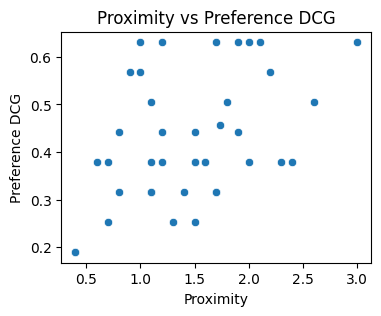

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.scatterplot(x=[x['proximity'] for x in score_dict], y=[x['preference_dcg'] for x in score_dict], ax=ax)
ax.set_xlabel('Proximity')
ax.set_ylabel('Preference DCG')
ax.set_title('Proximity vs Preference DCG')

In [108]:
# Count the number of counterfactuals that are actionable
actionable_cfs = [cf for cf in score_dict if cf['actionability'] == 1]
print(f'Number of actionable counterfactuals found: {len(actionable_cfs)}')

Number of actionable counterfactuals found: 0
